# 6.3 ハミルトニアンモンテカルロ法(Hamiltonian Monte Carlo, HMC)

In [1]:
# パッケージの読み込み
using Distributions, PyPlot, ForwardDiff, LinearAlgebra

In [2]:
# n次元単位行列
eye(n) = Diagonal{Float64}(I, n)

# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [3]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

## 6.3.1 マルコフ連鎖モンテカルロ(Markov chain Monte Carlo, MCMC)

## 6.3.2 メトロポリスヘイスティングス法(Metropolis-Hastings method)

In [4]:
# ガウス提案分布によるメトロポリスヘイスティングス法
function GaussianMH(log_p_tilde, μ₀; maxiter::Int=100_000, σ::Float64=1.0)
    # サンプルを格納する配列
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    # 初期サンプル
    μ_samples[:, 1] = μ₀
    
    # 受容されたサンプルの数
    num_accepted = 1
    
    for i in 2:maxiter
        # 提案分布 q (多変量正規分布)に従い、次のサンプル候補を抽出
        μ_tmp = rand(MvNormal(μ_samples[:, i-1], σ * eye(D)))
        
        # 比率 r (の対数)を計算
        log_r = (log_p_tilde(μ_tmp) +
                 logpdf(MvNormal(μ_tmp, σ), μ_samples[:, i-1])) -
                (log_p_tilde(μ_samples[:, i-1]) +
                 logpdf(MvNormal(μ_samples[:, i-1], σ), μ_tmp))
        # 確率 r でサンプルを受容する
        is_accepted = min(1, exp(log_r)) > rand()
        new_samples = is_accepted ? μ_tmp : μ_samples[:, i-1]
        
        # 新しいサンプルを格納
        μ_samples[:, i] = new_samples
        
        # 受容された場合、合計をプラスする
        num_accepted += is_accepted
    end
    
    μ_samples, num_accepted
end

GaussianMH (generic function with 1 method)

## ハミルトニアンモンテカルロ法の手続き

In [5]:
# ハミルトニアンモンテカルロ法
function HMC(log_p_tilde, μ₀; maxiter::Int=100_000, L::Int=100, ϵ::Float64=1e-1)
    # leapfrogによる値の更新
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    
    # 非正規化対数事後分布の勾配関数を計算
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    
    # サンプルを格納する配列
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    # 初期サンプル
    μ_samples[:, 1] = μ₀
    
    # 受容されたサンプルの数
    num_accepted = 1
    
    for i in 2:maxiter
        # 運動量 p の生成
        p_in = randn(size(μ₀))
        
        # リープフロッグ法
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
                
        # 比率 r (の対数)を計算
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        
        # 確率 r でサンプルを受容する
        is_accepted = min(1, exp(log_r)) > rand()
        new_samples = is_accepted ? μ_out : μ_in
        
        # 新しいサンプルを格納
        μ_samples[:, i] = new_samples
        
        # 受容された場合、合計をプラスする
        num_accepted += is_accepted
    end
    
    μ_samples, num_accepted
end

HMC (generic function with 1 method)

In [6]:
# 最適化のラッパー関数の定義
function inference_wrapper_GMH(log_joint, paras, w_init; 
                               maxiter::Int=100000, σ::Float64=1.0)
    ulp(w) = log_joint(w, paras...)
    GaussianMH(ulp, w_init; maxiter=maxiter, σ=σ)
end

function inference_wrapper_HMC(log_joint, paras, w_init; 
                               maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, paras...)
    HMC(ulp, w_init, maxiter=maxiter, L=L, ϵ=ϵ)
end

inference_wrapper_HMC (generic function with 1 method)

## 6.3.5 ロジスティック回帰

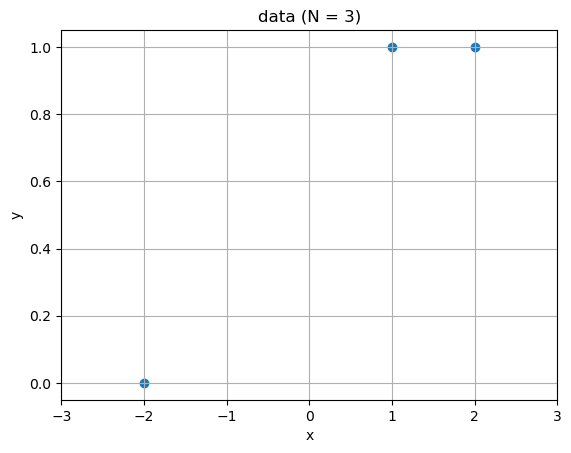

In [7]:
# 入力データセット
X_obs = [-2, 1, 2]

# 出力データセット
Y_obs = Bool.([0, 1, 1])

# 散布図で可視化
fig, ax = subplots()
ax.scatter(X_obs, Y_obs)
ax.set_xlim([-3, 3])
set_options(ax, "x", "y", "data (N = $(length(X_obs)))")

In [8]:
# シグモイド関数
sig(x) = 1/(1 + exp(-x))

# 事前分布の設定
σ = 0.0
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0

10.0

In [9]:
# 対数同時分布
log_joint(w, X, Y, σ, μ₁, σ₁, μ₂, σ₂) = 
    logpdf(Normal(μ₁, σ₁), w[1]) +
    logpdf(Normal(μ₂, σ₂), w[2]) +
    sum(logpdf.(Bernoulli.(sig.(w[1]*X .+ w[2])), Y))

# 非正規化対数事後分布
paras = (X_obs, Y_obs, σ, μ₁, σ₁, μ₂, σ₂)
ulp(w) = log_joint(w, paras...)

ulp (generic function with 1 method)

In [10]:
# 初期値
w_init = randn(2)

# サンプリング
maxiter = 300
param_posterior_GMH, num_accepted_GMH =
    inference_wrapper_GMH(log_joint, paras, w_init, maxiter=maxiter, σ=1.0)
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, w_init, maxiter=maxiter, L=10, ϵ=1e-1)

([-1.148033288254651 -0.02371441446324829 … 9.088116984556763 8.653794669192154; -0.9345066210875994 -0.7735838338826597 … -5.739245510182496 -6.527793916021993], 300)

acceptance rate (GMH) = 0.8333333333333334


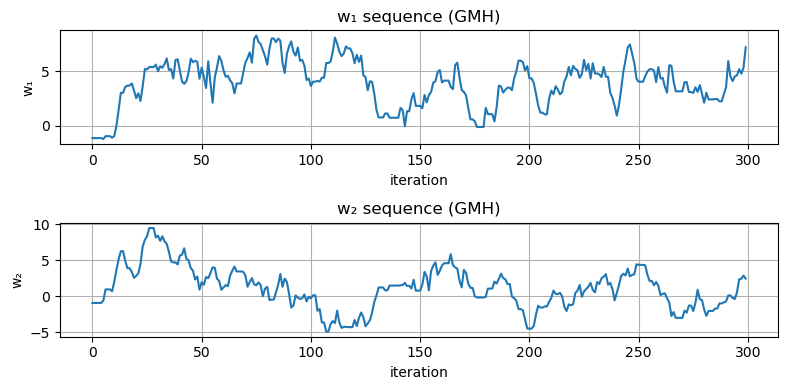

In [11]:
# サンプリングの過程を可視化(Gaussian MH)
fig, axes = subplots(2, 1, figsize=(8, 4))
axes[1].plot(param_posterior_GMH[1, :])
set_options(axes[1], "iteration" , "w₁", "w₁ sequence (GMH)")
axes[2].plot(param_posterior_GMH[2, :])
set_options(axes[2], "iteration" , "w₂", "w₂ sequence (GMH)")
tight_layout()
println("acceptance rate (GMH) = $(num_accepted_GMH/maxiter)")

acceptance rate (HMC) = 1.0


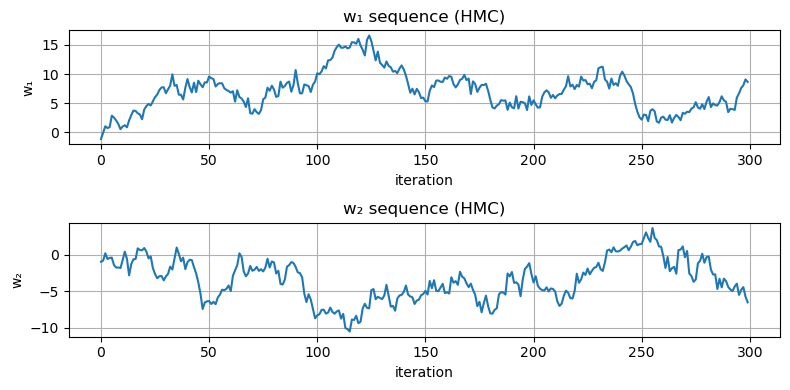

In [12]:
# サンプリングの過程を可視化(HMC)
fig, axes = subplots(2, 1, figsize=(8, 4))
axes[1].plot(param_posterior_HMC[1, :])
set_options(axes[1], "iteration" , "w₁", "w₁ sequence (HMC)")
axes[2].plot(param_posterior_HMC[2, :])
set_options(axes[2], "iteration" , "w₂", "w₂ sequence (HMC)")
tight_layout()
println("acceptance rate (HMC) = $(num_accepted_HMC/maxiter)")

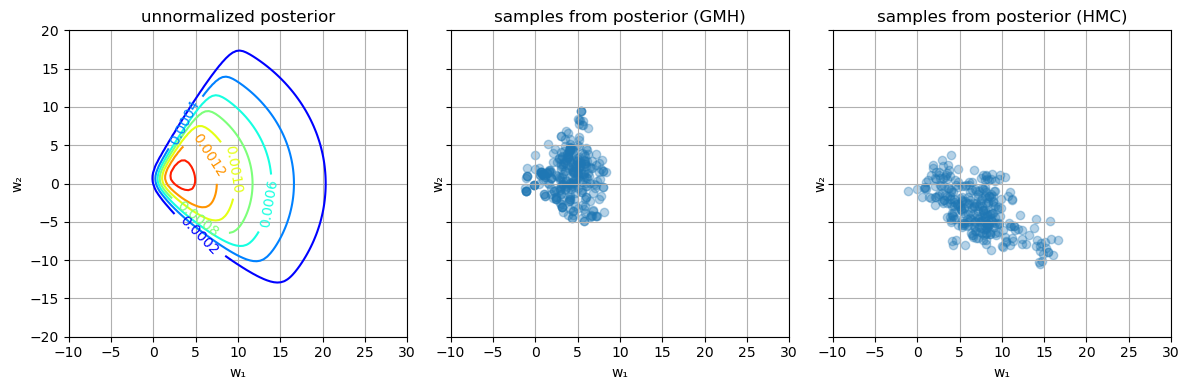

In [13]:
# 事後分布を可視化する範囲
w₁s = range(-10, 30, length=100)
w₂s = range(-20, 20, length=100)

fig, axes = subplots(1, 3, sharex=true, sharey=true, figsize=(12, 4))

# 非正規化事後分布の可視化
cs = axes[1].contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) + eps() for w₁ in w₁s, w₂ in w₂s]', cmap="jet")
axes[1].clabel(cs, inline=true)
set_options(axes[1], "w₁", "w₂", "unnormalized posterior")

# Gaussian MHから得られた事後分布からのサンプル
axes[2].scatter(param_posterior_GMH[1,:], param_posterior_GMH[2,:], alpha=100/maxiter)
set_options(axes[2], "w₁", "w₂", "samples from posterior (GMH)")

# HMCから得られた事後分布からのサンプル
axes[3].scatter(param_posterior_HMC[1,:], param_posterior_HMC[2,:], alpha=100/maxiter)
set_options(axes[3], "w₁", "w₂", "samples from posterior (HMC)")

tight_layout()

In [14]:
param_posterior_GMH, num_accepted_GMH =
    inference_wrapper_GMH(log_joint, paras, w_init, maxiter=maxiter, σ=10.0)
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, w_init, maxiter=maxiter, L=10, ϵ=1e-0)

([-1.148033288254651 31.381387398299708 … 24.473686408085218 9.02045430528413; -0.9345066210875994 1.2404380745302617 … -8.106879606133766 2.298405726267739], 294)

acceptance rate (GMH) = 0.7433333333333333


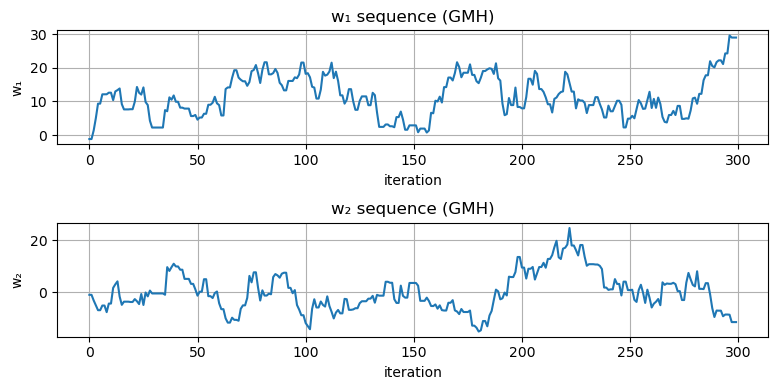

In [15]:
# サンプリングの過程を可視化(Gaussian MH)
fig, axes = subplots(2, 1, figsize=(8, 4))
axes[1].plot(param_posterior_GMH[1, :])
set_options(axes[1], "iteration" , "w₁", "w₁ sequence (GMH)")
axes[2].plot(param_posterior_GMH[2, :])
set_options(axes[2], "iteration" , "w₂", "w₂ sequence (GMH)")
tight_layout()
println("acceptance rate (GMH) = $(num_accepted_GMH/maxiter)")

acceptance rate (HMC) = 0.98


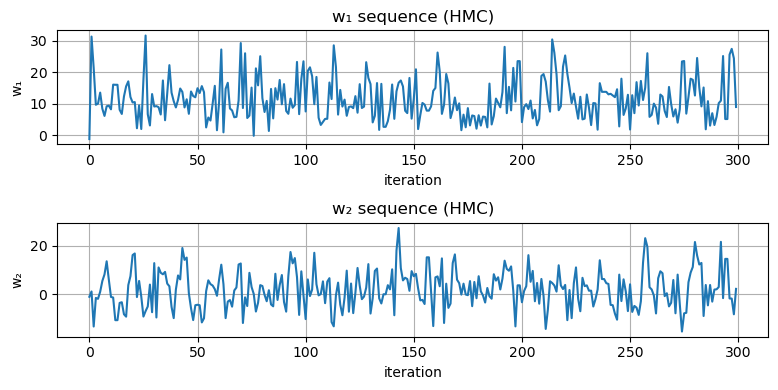

In [16]:
# サンプリングの過程を可視化(HMC)
fig, axes = subplots(2, 1, figsize=(8, 4))
axes[1].plot(param_posterior_HMC[1, :])
set_options(axes[1], "iteration" , "w₁", "w₁ sequence (HMC)")
axes[2].plot(param_posterior_HMC[2, :])
set_options(axes[2], "iteration" , "w₂", "w₂ sequence (HMC)")
tight_layout()
println("acceptance rate (HMC) = $(num_accepted_HMC/maxiter)")

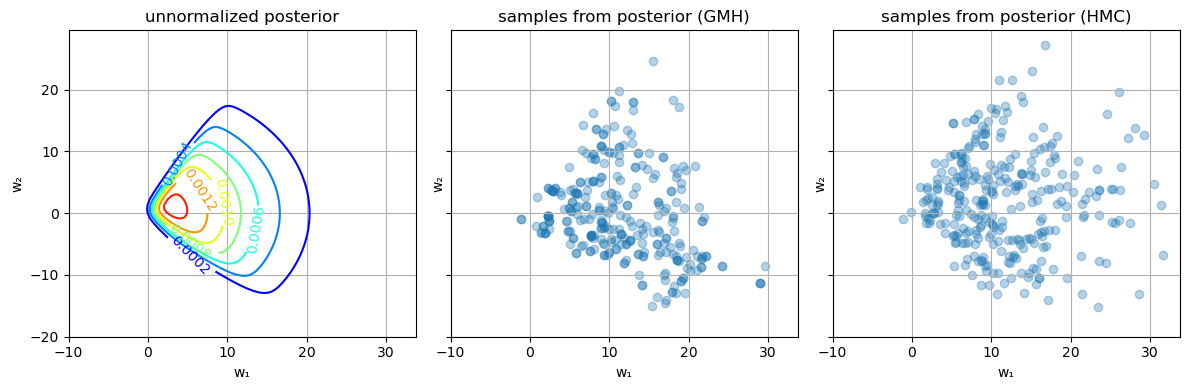

In [17]:
# 事後分布を可視化する範囲
w₁s = range(-10, 30, length=100)
w₂s = range(-20, 20, length=100)

fig, axes = subplots(1, 3, sharex=true, sharey=true, figsize=(12, 4))

# 非正規化事後分布の可視化
cs = axes[1].contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) + eps() for w₁ in w₁s, w₂ in w₂s]', cmap="jet")
axes[1].clabel(cs, inline=true)
set_options(axes[1], "w₁", "w₂", "unnormalized posterior")

# Gaussian MHから得られた事後分布からのサンプル
axes[2].scatter(param_posterior_GMH[1,:], param_posterior_GMH[2,:], alpha=100/maxiter)
set_options(axes[2], "w₁", "w₂", "samples from posterior (GMH)")

# HMCから得られた事後分布からのサンプル
axes[3].scatter(param_posterior_HMC[1,:], param_posterior_HMC[2,:], alpha=100/maxiter)
set_options(axes[3], "w₁", "w₂", "samples from posterior (HMC)")

tight_layout()

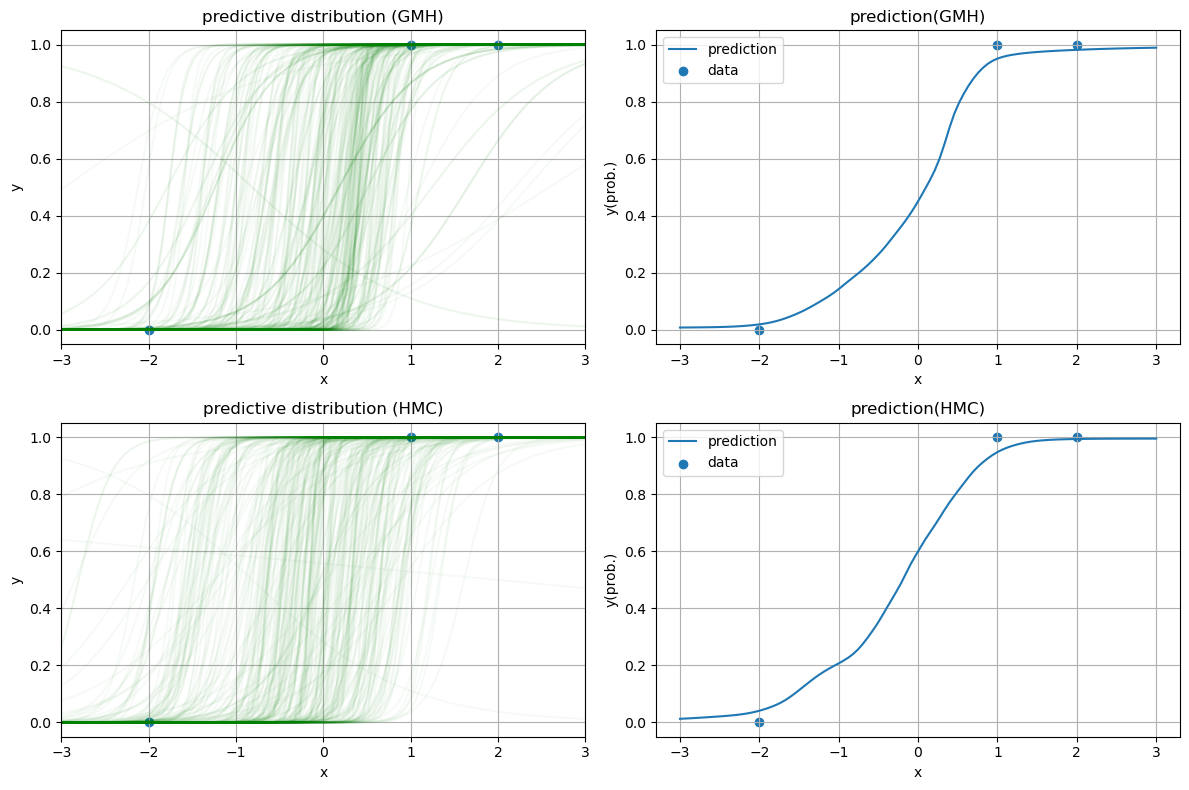

In [18]:
# 関数を可視化する範囲
xs = range(-3, 3, length=100)

fig, axes = subplots(2, 2, figsize=(12, 8))

# Gaussian MH によるサンプル
fs = []
for i in 1:size(param_posterior_GMH, 2)
    w₁, w₂ = param_posterior_GMH[:, i]
    f(x) = sig(w₁ * x + w₂)
    push!(fs, f.(xs))
    axes[1,1].plot(xs, f.(xs), "g", alpha=10/maxiter)
end
axes[1,1].scatter(X_obs, Y_obs)
axes[1,1].set_xlim(extrema(xs))
set_options(axes[1,1], "x", "y", "predictive distribution (GMH)")

# GMHによる予測の平均
axes[1,2].plot(xs, mean(fs), label="prediction")
axes[1,2].scatter(X_obs, Y_obs, label="data")
set_options(axes[1,2], "x", "y(prob.)", "prediction(GMH)", legend=true)

# HMC によるサンプル
fs = []
for i in 1:size(param_posterior_HMC, 2)
    w₁, w₂ = param_posterior_HMC[:, i]
    f(x) = sig(w₁ * x + w₂)
    push!(fs, f.(xs))
    axes[2,1].plot(xs, f.(xs), "g", alpha=10/maxiter)
end
axes[2,1].scatter(X_obs, Y_obs)
axes[2,1].set_xlim(extrema(xs))
set_options(axes[2,1], "x", "y", "predictive distribution (HMC)")

# HMCによる予測の平均
axes[2,2].plot(xs, mean(fs), label="prediction")
axes[2,2].scatter(X_obs, Y_obs, label="data")
set_options(axes[2,2], "x", "y(prob.)", "prediction(HMC)", legend=true)

tight_layout()